In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "11_adv_problems/11a_counting.ipynb"
_nb_title = "Counting objects based on density"
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Counting+objects+based+on+density&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F11_adv_problems%2F11a_counting.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/11_adv_problems/11a_counting.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/11_adv_problems/11a_counting.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/11_adv_problems/11a_counting.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# 密度に基づいたオブジェクトのカウンティング
このノートブックでは、密度に基づいて画像内のオブジェクトの数を数える方法を示します。<br>
この方法では、必ずしも個々のオブジェクトを正しく識別する必要はありません。

## GPUの有効化

Colab:
- [Edit]→[Notebook Setting]へ移動
- [Hardware Accelerator]ドロップダウンから[TPU]を選択

Vertex AI Workbench:
- https://console.cloud.google.com/vertex-ai/workbench/list/instances に移動
- [New Notebook] -> [TensorFlow Enterprise] -> [TensorFlow Enterprise 2.8] -> [With 1 NVIDIA Tesla T4] -> [Install NVIDIA GPU driver automatically for me]にチェック -> [Create] でインスタンスを作成



In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.8.1
Found GPU at: /device:GPU:0


2022-07-31 13:47:10.613838: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-31 13:47:11.235821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 13:47:11.247749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 13:47:11.248480: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## 画像とパッチの生成

96 berries simulated


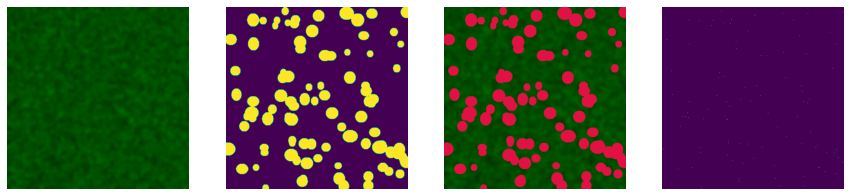

In [3]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import scipy.ndimage as ndimage
from skimage import draw

FULL_IMG_WIDTH = 512
FULL_IMG_HEIGHT = 512
IMG_CHANNELS = 3
PATCH_WIDTH = 64
PATCH_HEIGHT = 64
INPUT_WIDTH = PATCH_WIDTH*2
INPUT_HEIGHT = PATCH_HEIGHT*2

def generate_image(with_intermediates=False):
  # the image has a random greenish background that is smoothed
  backgr = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH, IMG_CHANNELS])
  backgr[np.random.rand(FULL_IMG_HEIGHT, FULL_IMG_WIDTH) < 0.3, 1] = 1
  backgr = ndimage.gaussian_filter(backgr, sigma=(5, 5, 0), order=0)

  # between 25 and 100 berries randomly placed
  num_berries = np.random.randint(25,100)
  berry_cx = np.random.randint(0, FULL_IMG_WIDTH, size=num_berries)
  berry_cy = np.random.randint(0, FULL_IMG_HEIGHT, size=num_berries)
  label = np.zeros([FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
  label[berry_cx, berry_cy] = 1

  # draw the berries which are 10 px in radius
  berries = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
  for idx in range(len(berry_cx)):
    radius = np.random.randint(10, 20)
    ratio = np.random.uniform(0.8, 1.2)
    rr, cc = draw.ellipse(berry_cx[idx], berry_cy[idx],
                         radius, radius*ratio, 
                         shape=berries.shape)
    berries[rr, cc] = 1

  # add berries to the background
  img = np.copy(backgr)
  r = np.random.uniform(0.8, 1)
  g, b = np.random.uniform(0, 0.2), np.random.uniform(0, 0.3)
  img[berries > 0] = [r, g, b] # red
  # img[berries > 0] = [1, 0, 0] # red

  if with_intermediates:
    print("{} berries simulated".format(num_berries))
    return backgr, berries, img, label
  else:
    return img, label

images = generate_image(True)
f, ax = plt.subplots(1, len(images), figsize=(15, 5))
for idx, img in enumerate(images):
  ax[idx].imshow(img)
  ax[idx].axis('off')

In [4]:
## given an image, get the patches
def get_patches(img, label, verbose=False):
  img = tf.expand_dims(img, axis=0)
  label = tf.expand_dims(tf.expand_dims(label, axis=0), axis=-1)
  if verbose:
    print(img.shape, label.shape)
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  patches = tf.image.extract_patches(img, 
                                     sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                                     strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                     rates=[1, 1, 1, 1],
                                     padding='SAME',
                                     name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  labels = tf.image.extract_patches(label,
                                    sizes=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    rates=[1, 1, 1, 1],
                                    padding='VALID',
                                    name='get_labels')
  labels = tf.reshape(labels, [num_patches, -1])
  # the "density" is the number of points in the label patch
  patch_labels = tf.math.reduce_sum(labels, axis=[1], name='calc_density')
  if verbose:
    print(patches.shape, labels.shape, patch_labels.shape)
  return patches, patch_labels

## 密度推定回帰モデルの学習

In [5]:
# Getting input data
def create_dataset(num_full_images):
  def generate_patches():
    for i in range(num_full_images):
      img, label = generate_image()
      patches, patch_labels = get_patches(img, label)
      for patch, patch_label in zip(patches, patch_labels):
        yield patch, patch_label

  return tf.data.Dataset.from_generator(
    generate_patches,
    (tf.float32, tf.float32), # patch, patch_label
    (tf.TensorShape([INPUT_HEIGHT*INPUT_WIDTH*IMG_CHANNELS]),
    tf.TensorShape([]))  
  )

trainds = create_dataset(1) # will create 256 patches per image
for img, label in trainds.take(3):
  avg = tf.math.reduce_mean(img) # avg pixel in image
  print(img.shape, label.numpy(), avg.numpy())

(49152,) 1.0 0.06932958
(49152,) 0.0 0.093743525
(49152,) 1.0 0.082388826


2022-07-31 13:47:12.253054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 13:47:12.253807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 13:47:12.254374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 13:47:12.255317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-31 13:47:12.255949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 random_color_distortion (Ra  (None, 128, 128, 3)      0         
 ndomColorDistortion)                                            
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0

2022-07-31 13:47:13.965472: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


2000/2000 [==============================] - 184s 90ms/step - loss: 0.8980 - mse: 0.3754 - mae: 0.3533 - val_loss: 0.5790 - val_mse: 0.3821 - val_mae: 0.4369
Epoch 2/10
2000/2000 [==============================] - 181s 91ms/step - loss: 0.4255 - mse: 0.2145 - mae: 0.3052 - val_loss: 0.3966 - val_mse: 0.1739 - val_mae: 0.2714
Epoch 3/10
2000/2000 [==============================] - 182s 91ms/step - loss: 0.3767 - mse: 0.1412 - mae: 0.2304 - val_loss: 0.3726 - val_mse: 0.1359 - val_mae: 0.2264
Epoch 4/10
2000/2000 [==============================] - 182s 91ms/step - loss: 0.3638 - mse: 0.1185 - mae: 0.2089 - val_loss: 0.3482 - val_mse: 0.1006 - val_mae: 0.1941
Epoch 5/10
2000/2000 [==============================] - 182s 91ms/step - loss: 0.3613 - mse: 0.1092 - mae: 0.1938 - val_loss: 0.3572 - val_mse: 0.1069 - val_mae: 0.1885
Epoch 6/10
2000/2000 [==============================] - 181s 91ms/step - loss: 0.3518 - mse: 0.0999 - mae: 0.1840 - val_loss: 0.3772 - val_mse: 0.1253 - val_mae: 0.21

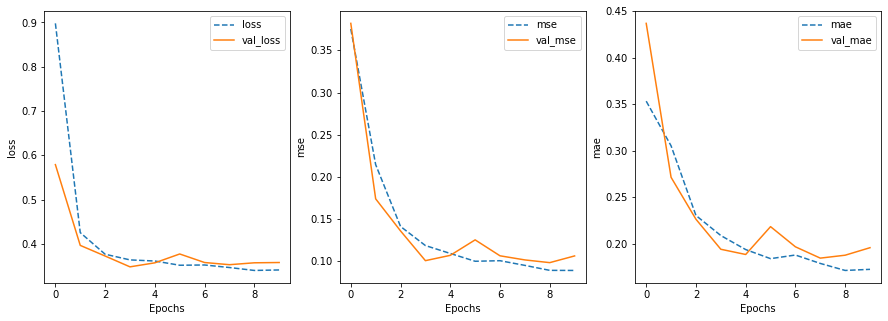

In [6]:
# Train
NUM_TRAIN = 1000 # 10000 more realistic
NUM_EVAL = 100 # 1000 more realistic
NUM_EPOCHS = 10

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

class RandomColorDistortion(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.5, 1.5], 
                 brightness_delta=[-0.2, 0.2], **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
    
    def call(self, images, training=None):
        if not training:
            return images
        
        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])
        
        images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        images = tf.clip_by_value(images, 0, 1)
        return images
    

def train_and_evaluate(batch_size = 32,
                       lrate = 0.002, # default in Adam constructor
                       l1 = 0.0003,
                       l2 = 0.0003,
                       num_filters = 32):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)
  train_dataset = create_dataset(NUM_TRAIN).batch(batch_size)
  eval_dataset = create_dataset(NUM_EVAL).batch(64)

  # a simple convnet. you can make it more complex, of course.
  # the patch is flattened, so we start by reshaping to an image.
  model = tf.keras.Sequential([
              tf.keras.layers.Reshape([INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS],
                                      input_shape=[INPUT_WIDTH * INPUT_HEIGHT * IMG_CHANNELS]),
              RandomColorDistortion(),
              tf.keras.layers.Conv2D(num_filters, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(num_filters*2,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(1, activation='linear')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.mean_squared_error,
                  metrics=['mse', 'mae'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
  training_plot(['loss', 'mse', 'mae'], history)
  return model

model = train_and_evaluate()

81 berries simulated
97 berries simulated
44 berries simulated
71 berries simulated
64 berries simulated
91 berries simulated
82 berries simulated
92 berries simulated
64 berries simulated
86 berries simulated
79 berries simulated
95 berries simulated
61 berries simulated
58 berries simulated
40 berries simulated
44 berries simulated


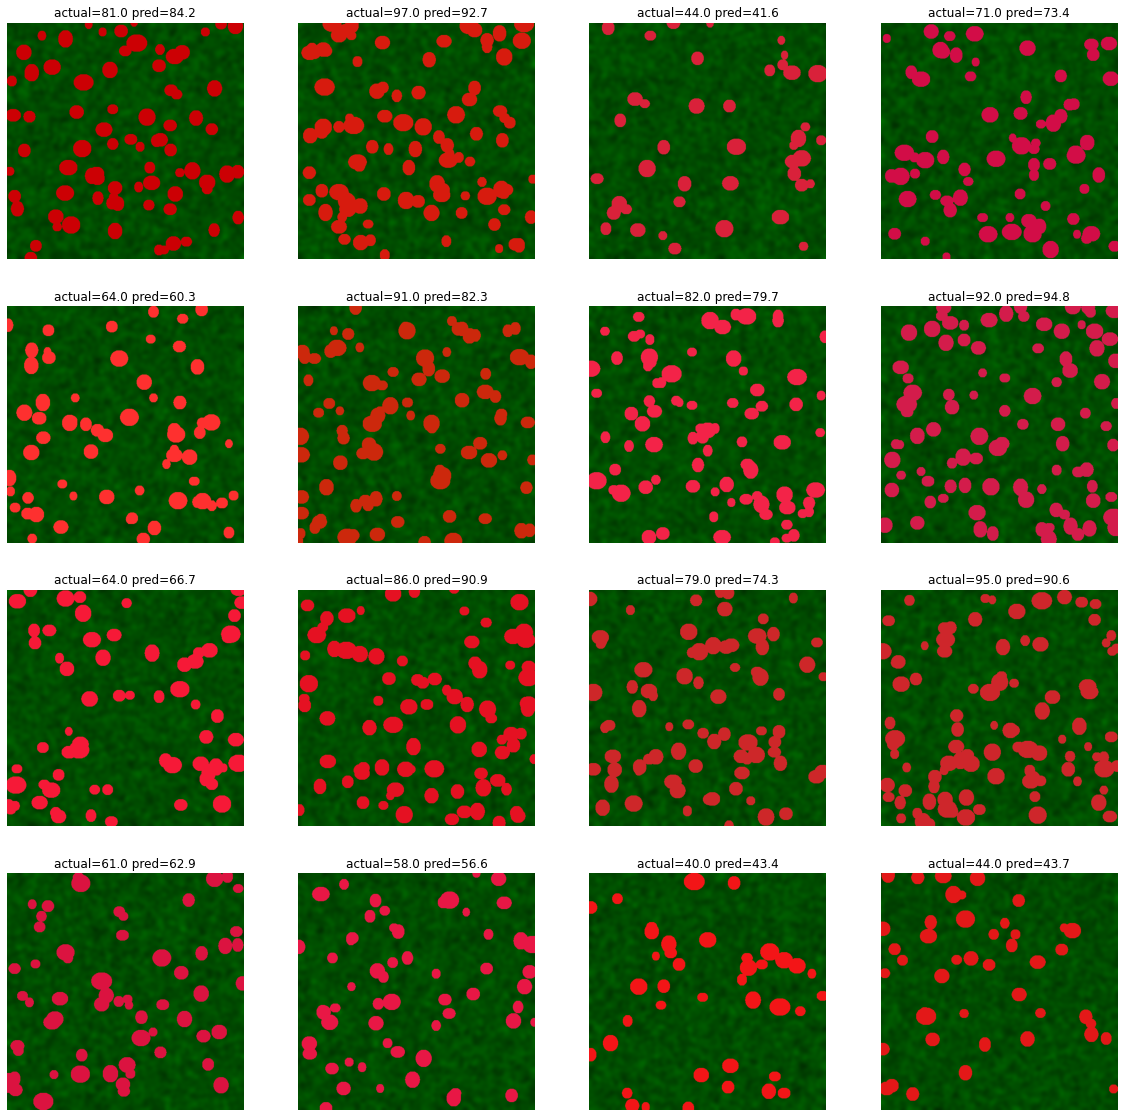

In [7]:
## prediction.
def count_berries(model, img):
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  img = tf.expand_dims(img, axis=0)
  patches = tf.image.extract_patches(img,
                sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                rates=[1, 1, 1, 1],
                padding='SAME',
                name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  densities = model.predict(patches)
  return tf.reduce_sum(densities)

# use an example image
f, ax = plt.subplots(4, 4, figsize=(20, 20))
for idx in range(16):
  backgr, berries, img, label = generate_image(True)
  ax[idx//4, idx%4].imshow(img)
  ax[idx//4, idx%4].set_title("actual={:.1f} pred={:.1f}".format(
    tf.reduce_sum(label).numpy(),
    count_berries(model, img).numpy()
  ))
  ax[idx//4, idx%4].axis('off')

## 実際の画像  

実際のベリーの画像で試してみましょう  

<img height="512" width="512" src="berries.jpg"/>

In [8]:
!file berries.jpg

berries.jpg: PNG image data, 680 x 706, 8-bit/color RGB, non-interlaced


In [9]:
contents = tf.io.read_file('./berries.jpg')
img = tf.image.decode_image(contents)
img = tf.image.resize(img, [FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
img = img / 255
n = count_berries(model, img)
print(n.numpy())

317.3496


実際には約65個程度のベリーが写っているようです。

シュミレーションデータで学習をしているので、シュミレーションデータと推論時のデータに大きな乖離があると、結果に悪い影響がでます。<br>
その際は、異なるサイズのベリーを使用したり、背景の工夫をしたりといったシミュレーションの改善や、実データを学習データに含めることを考慮してみるとよいでしょう。

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.